## Process water logger data and calculate correspondence with radar data

#### Aim:
- To test if the water logger data can be used to derive a transfer function between water level and HH backscatter

#### Inputs: 
- water table depth along transects
- water logger data
- daily interpolated radar data

#### Conclusion:
- differences in the slope of the water-level ~ HH linear regression between the water loggers, means that the water logger placements are not likely representative of the average elevation of the surrounding terrain, and as a result can't be used to confidently derive a transfer function. 

#### Follow up analysis:
- the water level relationship is derived in the next code: Determine_transfer_function_WTD_transects.ipynb using the water table depths measured along transects instead. 
- the water logger temporal patterns are used for validation of the derived function. 


In [ ]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats

%xmode Minimal

In [ ]:
# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

In [3]:
# include the input/output directory paths here:



In [37]:
def extract_HH(df,coords):
    # extracts the HH backscatter values corresponding with the dates and logger locations
    # set up to work with the Ekolongouma data format
    # example usage: extract_HH(EKG_loggers, EKG_coords)
    
    df['HH_db'] = np.nan
    df['HH_db_orig'] = np.nan
    
    # looping through the loggers 
    for i in range(len(coords)):
        lat1 = coords['lat'][i]
        lon1 = coords['lon'][i]

        logger_name = coords['Logger'][i]
        print ("Extracting the HH backscatter values for: " + logger_name + ' lat: ' + str(lat1) + ', lon: ' + str (lon1))

        # looping through the rows (date-time steps)
        for j in range(len(df)):
            # the date to extract the backscatter value on

            if df['logger'][j] == logger_name:    
                dt1 = df['Datetime'][j]
                df['HH_db'][j] = HH_daily_fb.sel(time=dt1,lon=lon1,lat=lat1, method='nearest')['db']    
                df['HH_db_orig'][j] = HH_db_100m.sel(time=dt1,lon=lon1,lat=lat1, method='nearest')['db']

    df = df.copy().drop(['temperature'],axis=1)
    
    return df
    

In [1]:
def process_EKG_1040(df,ID):
    # extracting the 10:40 times from the EKG logger data
    # example usage: process_EKG_1040(EKG02_1040,'EKG02')
    
    # Adding a logger ID column
    df['logger']= ID
      
    # Converting the datetime column to python datetime
    df['Dates'] = pd.to_datetime(df['datetime'], dayfirst=True, format='%d/%m/%Y %H:%M')
    
    # splitting into Day and time
    df['Day'] = df['Dates'].dt.strftime('%d/%m/%Y')
    df['times'] = df['Dates'].dt.strftime('%H:%M')

    # depth for EKG loggers was done with -ve depths above the surface, so changing this for correspondence with the DRC data
    df['depth'] = -df['depth']
    
    # now dropping all times that are not 10:40
    df = df[df['times']=='10:40'].reset_index(drop=True)
    
    # dropping the unnecessary columns
    df = df.drop(['datetime','times'],axis=1)

    return (df)

In [ ]:
def remove_dates(df1,df2,col_name):
    # identifies differences in dates between the two logger dataframes and removes those rows
    # e.g. usage: remove_dates(loggers_mean,loggers_stdev,'Day')
    idx1 = df1.index
    idx2 = df2.index
    dates_to_remove = idx1.difference(idx2)
    print ("Dates to be removed: ", dates_to_remove)
    
    # removing these dates
    df1_new = df1[~df1.index.isin(dates_to_remove)]
    df2_new = df2[~df2.index.isin(dates_to_remove)]
            
    return (df1_new,df2_new)

In [ ]:
def calculate_deltaWL(da,logger,coords,NW):
    # function to calculate the daily change in water level for the specified water logger
    # e.g. usage: calculat_deltaWL(l_median,'LOK5_1.0',l_coords, NW_daily)
    
    da = da[['Datetime',logger]]
    da['deltaWL'] = np.nan

    # adding the NW daily column
    print (logger)
    lat1 = coords[coords['Logger']==logger]['lat']
    lon1 = coords[coords['Logger']==logger]['lon'] 
    
    NW_list = nw_daily['accum'].sel(lon=lon1,lat=lat1,method='nearest')
    NW_df = NW_list.to_dataframe().reset_index().rename({'time':'Datetime'},axis=1)   
    da2 = da.merge(NW_df, how='left',on='Datetime')
    
    # changing the depth to mm (to correspond with NW input)
    da2['deltaWL'] = 10*da2['deltaWL']
    print (da2)
    
    # adding a column with the change in water level between subsequent dates
    for i in range(1,len(da2)):
        da2['deltaWL'][i] =da2[logger][i]-da2[logger][i-1]
    
    # plotting
    # checking for relationdhip where the water level is 0 or above (saturated soil)
    da3 = da2[da2[logger]>=0]
  
    g = sns.lmplot(x='accum',y='deltaWL', data=da3, hue='Datetime')
    
    return(da2)

In [ ]:
# reading in the datasets

# version interpolated using NW input
# m-grid
#HH_daily_ds_m = xr.open_dataset(ALOS_OUT + 'HH_daily_m_grid_nearest_full_ts_all.nc')
HH_daily_ds_l = xr.open_dataset(ALOS_OUT + 'HH_linear_full_ts.nc')
#HH_daily = xr.open_dataset(ALOS_OUT + 'HH_daily_final.nc')

# the final daily interpolated data (using the forwards and backwards m-grid interpolations - interpolate to daily3 function output)
HH_daily_fb = xr.open_dataset(ALOS_OUT + 'HH_daily_mgrid_all_weighted_logistic.nc')

start_date = HH_daily_ds_l['time'][0]
end_date = HH_daily_ds_l['time'][-1]
print (np.array(start_date),np.array(end_date))

# HH data - 17 timesteps for area 2
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_area2.nc')

# HH:HV ratio
HHHV_db_100m = xr.open_dataset(ALOS_OUT+ 'HHHV_db_100m_area2.nc')

# transect data
transects_orig = pd.read_csv(GHG + 'Transect_CH4_fluxes.csv')

# water loggers - the original version with anomalous data - Bart 
loggers = pd.read_csv(GHG + 'loggers.csv')

# water loggers - the new version that Bart sent May 2022
#loggers = pd.read_csv(GHG + 'loggers2.csv')

# Ekolongouma logger data (median values)
EKG02 = pd.read_csv(GHG + 'EKG02.csv')
EKG03 = pd.read_csv(GHG + 'EKG03.csv')

# Ekolongouma sub-hourly data (use this to extract the 10:40am values)
EKG02_1040 = pd.read_csv(GHG + 'EKG02_1040.csv')
EKG03_1040 = pd.read_csv(GHG + 'EKG03_1040.csv')

# net water data
nw_daily_100m = xr.open_dataset(ALOS_OUT + 'nw_daily_new_100m.nc')
nw_daily_100m


In [10]:
transects_orig

,country,type_flux,transect,code,season,transect_season,transect_code,km_number,km,measuring_point,WTD_corrected,CH4_mg,Latitude,Longitude,date
0,DRC,peat,Boboka,BOB1,dry,Itanga-dry,ITG_3.1,3,km.3,1,-73.0,-0.02,1.208510,17.460870,10/03/2019
1,DRC,peat,Boboka,BOB1,dry,Itanga-dry,ITG_3.2,3,km.3,2,-73.0,0.03,1.208510,17.460870,10/03/2019
2,DRC,peat,Boboka,BOB1,dry,Itanga-dry,ITG_3.3,3,km.3,3,-73.0,-0.02,1.208510,17.460870,10/03/2019
3,DRC,peat,Boboka,BOB1,dry,Itanga-dry,ITG_3.4,3,km.3,4,-73.0,-0.21,1.208510,17.460870,10/03/2019
4,DRC,peat,Boboka,BOB1,dry,Itanga-dry,ITG_3.5,3,km.3,5,-73.0,0.17,1.208510,17.460870,10/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,RoC,peat,Itanga,ITG,dry,Lobaka-dry,LBK_5.4,5,km.5,4,32.0,18.10,0.989113,18.555450,01/03/2020
354,RoC,peat,Itanga,ITG,wet,Ipombo-wet,IPB_1.4,1,km.1,4,32.0,14.60,0.329375,18.241016,29/10/2020
355,RoC,peat,Itanga,ITG,wet,Ipombo-wet,IPB_1.2,1,km.1,2,34.0,14.60,0.329375,18.241016,29/10/2020
356,RoC,peat,Itanga,ITG,wet,Ipombo-wet,IPB_1.5,1,km.1,5,48.0,67.00,0.329375,18.241016,29/10/2020


In [ ]:
# starting from 29 Mar 2019
nw_daily = nw_daily_100m['net water'][421:].to_dataset(name='accum')
nw_daily

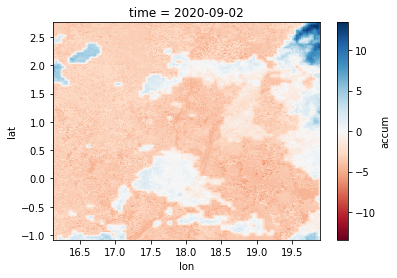

In [6]:
nw_daily['accum'][102][::5,::5].plot(cmap='RdBu')

In [9]:
# The radar data dates
#HH_times = HH_db_100m['time']
HH_times = ['2019-03-29T00:00:00.000000000', '2019-05-10T00:00:00.000000000',
       '2019-06-21T00:00:00.000000000', '2019-07-19T00:00:00.000000000',
       '2019-08-30T00:00:00.000000000', '2019-10-11T00:00:00.000000000',
       '2019-11-22T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
       '2020-02-14T00:00:00.000000000', '2020-03-27T00:00:00.000000000',
       '2020-05-08T00:00:00.000000000', '2020-06-19T00:00:00.000000000',
       '2020-07-17T00:00:00.000000000', '2020-08-28T00:00:00.000000000',
       '2020-10-09T00:00:00.000000000', '2021-10-08T00:00:00.000000000',
       '2021-11-19T00:00:00.000000000']

In [10]:
# creating a dataframe with the DRC logger coordinates
data = [['LOK5_1.0',-0.30320, 18.20069],['LOK5_3.0', -0.31495, 18.18710],['LOK5_4.0', -0.32095, 18.18046],['IKE1_5.0',  0.28348, 18.82755]]
l_coords = pd.DataFrame(data, columns = ['Logger','lat','lon'])
l_coords

,Logger,lat,lon
0,LOK5_1.0,-0.30320,18.20069
1,LOK5_3.0,-0.31495,18.18710
2,LOK5_4.0,-0.32095,18.18046
3,IKE1_5.0,0.28348,18.82755


In [11]:
# creating a dataframe with the RoC logger coordinates
data = [['EKG02',1.191986,17.84694 ],['EKG03',1.188695 , 17.83192]]
EKG_coords = pd.DataFrame(data, columns = ['Logger','lat','lon'])
EKG_coords

,Logger,lat,lon
0,EKG02,1.191986,17.84694
1,EKG03,1.188695,17.83192


## Processing the DRC data (LOK and IKE)

In [12]:
loggers = loggers.drop(['Day of year','Temperature'],axis=1)

In [ ]:
# calculating the median across the daily data
DRC_median = loggers.groupby(['Day']).median().reset_index()
DRC_median['Datetime'] = pd.to_datetime(DRC_median['Day'], dayfirst = True)
DRC_median.drop(['Day'], axis = 1, inplace = True)
DRC_median = DRC_median.sort_values('Datetime').reset_index(drop = True)
DRC_median.reset_index().plot('index','Datetime')

In [ ]:
# calculating the stdev across the daily data
# there are some missing dates where there are nan values
l_names = ['LOK5_1.0','LOK5_3.0','LOK5_4.0','IKE1_5.0']
DRC_stdev = loggers.groupby('Day',dropna=True).std()[l_names].dropna(how='all').sort_index(ascending=True).reset_index()

DRC_stdev['Datetime'] = pd.to_datetime(DRC_stdev['Day'], dayfirst = True)
DRC_stdev.drop(['Day'], axis = 1, inplace = True)
DRC_stdev = DRC_stdev.sort_values('Datetime').reset_index(drop = True)
DRC_stdev.reset_index().plot('index','Datetime')   

<AxesSubplot:xlabel='Datetime'>

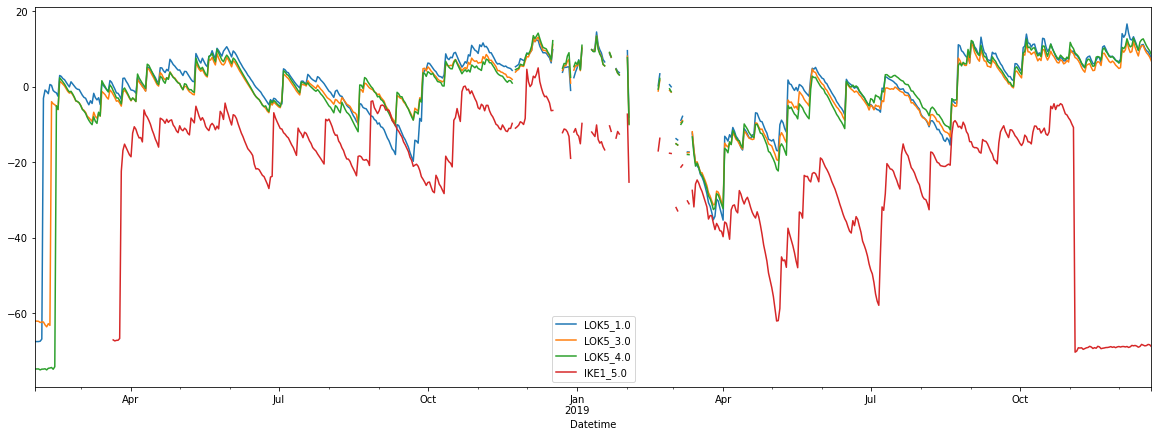

In [15]:
# Checking that the data looks sensible
plt.rcParams["figure.figsize"] = (20,7)
DRC_median.plot('Datetime',['LOK5_1.0','LOK5_3.0','LOK5_4.0','IKE1_5.0'])

In [16]:
# The standard deviations can only be calculated if there is more than one non-NaN daily value. 
# There are 2 days difference between the length of the calculated mean/median and stdev arrays
# Identifying these two dates, and removing them from the final arrays

# removing the date rows that are not common to both the stdev and mean/median arrays
DRC_median,DRC_stdev = remove_dates(DRC_median,DRC_stdev,'Datetime')


Dates to be removed:  Int64Index([639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651,
            652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
            665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677,
            678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688],
           dtype='int64')


In [17]:
# checking that the lengths of the median and stdev arrays are the same
print (len (DRC_stdev), len (DRC_median))

639 639


In [ ]:
# checking that there are no too large or small values in the final depth measurements.
# using the median means that the greatest depths are not present in the final data.
# this affects the max depths more than the min.
# is it better to use the 10:40 data, to correspond with the radar passover time? (see original Process_water_logger code)
print (DRC_median.max())

print (loggers.max())
print ('\n')

# minimum logged values
print (DRC_median.min())

print (loggers.min())

In [ ]:
# subsetting the logger dataframes using the start and end date values of the available HH radar data
l_median = DRC_median[(DRC_median['Datetime'] >= np.array(start_date)) & (DRC_median['Datetime']<=np.array(end_date))]
l_stdev = DRC_stdev[(DRC_stdev['Datetime'] >= np.array(start_date)) & (DRC_stdev['Datetime']<=np.array(end_date))]

# dropping rows where all loggers have nan value (due to too high daily standard deviations)
l_median = l_median.dropna(subset=l_names)
l_median = l_median.reset_index()

l_stdev = l_stdev.dropna(subset=l_names)
l_stdev = l_stdev.reset_index()

l_median

In [22]:
# adding columns with the nearest daily HH reflectivity value
l_median['HH_db_' + l_names[0]] = np.nan
l_median['HH_db_' + l_names[1]] = np.nan
l_median['HH_db_' + l_names[2]] = np.nan
l_median['HH_db_' + l_names[3]] = np.nan

df = l_median.copy()
    
# looping through the loggers 
for i in range(len(l_names)):
    lat1 = l_coords['lat'][i]
    lon1 = l_coords['lon'][i]

    print ("Extracting the HH backscatter values for: " + l_names[i] + ' lat: ' + str(lat1) + ', lon: ' + str (lon1))
        
    # looping through the rows (date-time steps)
    for j in range(len(df)):
        # the date to extract the backscatter value on
        dt1 = df['Datetime'][j]
        df['HH_db_' + l_names[i]][j] = HH_daily_fb.sel(time=dt1,lon=lon1,lat=lat1, method='nearest')['db']
        #transects['HH_db_linear'][i] = HH_db_linear.sel(time=dt1,lon=lon1,lat=lat1, method='nearest')['db']
        # some HH_db values are nan due to there not being close values for extraction - removing these
        #transects_df = transects.dropna()
    

l_median = df.copy()
l_median

Extracting the HH backscatter values for: LOK5_1.0 lat: -0.3032, lon: 18.20069
Extracting the HH backscatter values for: LOK5_3.0 lat: -0.31495, lon: 18.1871
Extracting the HH backscatter values for: LOK5_4.0 lat: -0.32095, lon: 18.18046
Extracting the HH backscatter values for: IKE1_5.0 lat: 0.28348, lon: 18.82755


,index,pressure_kpa,LOK5_1.0,LOK5_3.0,LOK5_4.0,IKE1_5.0,Datetime,HH_db_LOK5_1.0,HH_db_LOK5_3.0,HH_db_LOK5_4.0,HH_db_IKE1_5.0
0,421,NaN,-30.230183,-27.880474,-28.626599,-36.953991,2019-03-29,-7.254726,-7.002114,-7.682165,-7.656335
1,422,NaN,-32.021702,-28.923852,-29.884228,-38.092471,2019-03-30,-7.332380,-7.182412,NaN,-7.717231
2,423,NaN,-33.613732,-30.384363,-31.059585,-38.228373,2019-03-31,-7.165206,-6.862788,-4.370572,-7.651537
3,424,NaN,-35.293610,-31.509157,-32.251685,-39.686345,2019-04-01,-7.234586,-6.995669,-7.271266,-7.700499
4,425,NaN,-13.068663,-14.894757,-16.286702,-35.787488,2019-04-02,-7.300034,-7.124374,-10.063671,-7.746194
...,...,...,...,...,...,...,...,...,...,...,...
213,634,NaN,6.904910,6.112200,7.529518,-5.940898,2019-10-28,-5.854970,-5.661292,-3.866219,-6.771758
214,635,NaN,6.934145,6.394010,7.303273,-7.125790,2019-10-29,-6.051584,-6.114339,NaN,-6.790084
215,636,NaN,7.737718,7.014091,7.910439,-7.426266,2019-10-30,-5.743479,-5.646379,-3.221330,-6.758575
216,637,NaN,7.334646,6.601415,7.498448,-8.208368,2019-10-31,-5.951888,-6.129671,NaN,-6.856220


In [23]:
%%time
# re-arranging the dataframe column structure for easier plotting/data management
dfs = []
dfs_stdev = []
for i in range(len(l_names)):
    df_new = l_median[['Datetime',l_names[i],'HH_db_'+l_names[i]]]
    df_new = df_new.rename(columns={l_names[i]:'depth','HH_db_'+l_names[i]:'HH_db'})
    df_new['logger'] = l_names[i]
    dfs.append(df_new)
    
    # similarly for the stdev vaules
    df_new = l_stdev[['Datetime',l_names[i]]]
    df_new = df_new.rename(columns={l_names[i]:'depth'})
    df_new['logger'] = l_names[i]
    dfs_stdev.append(df_new)   
    
# merging these dataframes
#dfs = [df.set_index(['Day','logger']) for df in dfs]
loggers_df = pd.concat(dfs, axis=0).reset_index(drop=True)
loggers_stdev_df = pd.concat(dfs_stdev, axis = 0).reset_index(drop=True)
loggers_stdev_df

CPU times: user 8.44 ms, sys: 1.47 ms, total: 9.91 ms
Wall time: 9.32 ms


,Datetime,depth,logger
0,2019-03-29,0.580084,LOK5_1.0
1,2019-03-30,0.870370,LOK5_1.0
2,2019-03-31,0.684045,LOK5_1.0
3,2019-04-01,0.763779,LOK5_1.0
4,2019-04-02,11.470838,LOK5_1.0
...,...,...,...
1067,2019-12-17,0.316861,IKE1_5.0
1068,2019-12-18,0.308650,IKE1_5.0
1069,2019-12-19,0.459149,IKE1_5.0
1070,2019-12-20,0.478129,IKE1_5.0


In [ ]:
# merging the stdevs column into the main loggers_df dataframe
loggers_stdev_df.rename(columns = {'depth':'stdev'}, inplace = True)
loggers_df = pd.merge(left=loggers_df,right=loggers_stdev_df,left_on=['Datetime','logger'],right_on=['Datetime','logger'])
loggers_df

In [ ]:
# selecting only the dates with corresponding radar data (need to do this for the 10:40 timestep)
DRC_loggers_df = loggers_df[loggers_df['Datetime'].isin(HH_times)]
DRC_loggers_df

In [ ]:
# calculating the linear regression stats
# add in the EKG loggers
# 10:40am version to correspond with the radar data
df = DRC_loggers_df.copy()
#df = df[df['depth']>-20]
m, c, r, p, std_err = stats.linregress(df['HH_db'],df['depth'])
print ('depth = '+ str(m) + '*HH + ' + str(c))
print ('R = ' +str(r) + ', p-value = ' + str(p) + ', std error = ' + str(std_err))
sns.regplot(x='HH_db',y='depth',data=df)

### Processing the ROC EKG data

In [31]:
# Merging the Ekolongouma water logger datasets

EKG02['logger'] = 'EKG02'
EKG03['logger'] = 'EKG03'
EKG02

# combining these two 
EKG_loggers = pd.concat([EKG02,EKG03]).reset_index()

# changing day format to datetime
EKG_loggers['Datetime'] = pd.to_datetime(EKG_loggers['Day'], dayfirst = True)
#EKG_loggers.sort_values(by='Day', inplace=True)

# reducing to dates between the start and end dates of the ALOS-2 time-series
EKG_loggers = EKG_loggers[(EKG_loggers['Datetime']>=np.array(start_date)) & (EKG_loggers['Datetime']<=np.array(end_date))].reset_index()
EKG_loggers = EKG_loggers.drop(['level_0','index'], axis=1)

# The EKG data uses -ve values for above surface water levels, so multiplying through by -1
EKG_loggers['depth'] = EKG_loggers['depth']*-1.0
EKG_loggers

,Day,depth,temperature,logger,Datetime
0,29/03/2019,0.586342,24.9175,EKG02,2019-03-29
1,30/03/2019,-0.338401,23.7920,EKG02,2019-03-30
2,31/03/2019,0.923012,23.4020,EKG02,2019-03-31
3,01/04/2019,-0.520627,26.0075,EKG02,2019-04-01
4,02/04/2019,0.850037,23.4000,EKG02,2019-04-02
...,...,...,...,...,...
1096,04/10/2020,3.722195,23.3640,EKG03,2020-10-04
1097,05/10/2020,3.108800,22.4535,EKG03,2020-10-05
1098,06/10/2020,2.567519,24.0370,EKG03,2020-10-06
1099,07/10/2020,2.321056,21.6050,EKG03,2020-10-07


In [ ]:
# checking that the indexes and datetimes are correctly ordered
EKG_loggers.reset_index().plot.scatter('Datetime','index')

In [33]:
# checking logger depth ranges
print ('Ekolongouma 2 min depth: ' + str(EKG_loggers['depth'][EKG_loggers['logger']=='EKG02'].min()) + ', max depth: ' +str(EKG_loggers['depth'][EKG_loggers['logger']=='EKG02'].max()))
print ('Ekolongouma 3 min depth: ' + str(EKG_loggers['depth'][EKG_loggers['logger']=='EKG03'].min()) + ', max depth: ' +str(EKG_loggers['depth'][EKG_loggers['logger']=='EKG03'].max()))

Ekolongouma 2 min depth: -66.49815931, max depth: 29.21019952
Ekolongouma 3 min depth: -68.3741749, max depth: 19.0459492


In [34]:
EKG_coords['Logger'][0]
logger_name= EKG_coords['Logger'][0]
if EKG_loggers['logger'][655] == logger_name:
    print ('true')

In [ ]:
EKG_loggers_df = extract_HH(EKG_loggers, EKG_coords)
EKG_loggers_df

In [39]:
# selecting only the dates with corresponding radar data (need to do this for the 10:40 timestep)
EKG_loggers_df2 = EKG_loggers_df[EKG_loggers_df['Datetime'].isin(HH_times)]
EKG_loggers_df2.drop(['Day','HH_db_orig'],axis=1,inplace=True)

In [40]:
# (ignoring the stdev column in the DRC data for just now, until able to calculate similar for EKG)
DRC_loggers_df2 = DRC_loggers_df.drop('stdev', axis=1)

In [41]:
# combining EKG_loggers_df2 and DRC_loggers_df 
All_loggers_df = pd.concat([DRC_loggers_df2,EKG_loggers_df2],ignore_index=True)

In [42]:
# Plotting linear regression
# and calculating the linear regression stats
# 10:40am version to correspond with the radar data
df = All_loggers_df.copy()

# dropping an anomalous data point from IKE01
df.drop(labels=[22],inplace=True)
#df = df[df['depth']>-35]
# stats over all data points
m, c, r, p, std_err = stats.linregress(df['HH_db'],df['depth'])
print ('depth = '+ str(m) + '*HH + ' + str(c))
print ('R = ' +str(r) + ', p-value = ' + str(p) + ', std error = ' + str(std_err))

All_loggers_df = df.copy()

depth = 13.656363708883855*HH + 86.15458252856445
R = 0.4324493596311655, p-value = 0.0015286710858746352, std error = 4.067651378318055


In [43]:
all_names = ['EKG02','EKG03','LOK5_1.0', 'LOK5_3.0', 'LOK5_4.0', 'IKE1_5.0']

In [ ]:
df = All_loggers_df.copy()
df = df[df['HH_db']>-10]
df = df[df['logger'].isin(all_names[:5])]   # not including IKE1.

slope, intercept, r_value, p_value, std_err = stats.linregress(df['HH_db'],df['depth'])

print (" water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')
# use line_kws to set line label for legend
ax = sns.regplot(x="HH_db", y="depth", data=df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.axhline(0, ls='--')
# plot legend
ax.legend()
ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
ax.set_ylabel("Water depth (cm)", fontsize = 14)

In [ ]:
g = sns.lmplot(x="HH_db", y="depth", hue="logger", data=df, fit_reg=False,legend=False, markers=['o','o','o','x','x'],palette='colorblind')
plt.legend(loc='lower right')

sns.regplot(x="HH_db", y="depth", data=df, scatter=False, ax=g.axes[0, 0])
g.ax.axhline(0, ls='--',c='gray')
ax = g.axes[0,0]
g.ax.set_title("median depth = {0:.2f}HH + {1:.1f}".format(slope,intercept))
g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
g.ax.set_ylabel("Water depth (cm)", fontsize = 14)

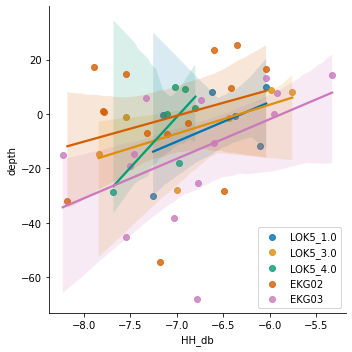

In [46]:
# individual regressions by logger
# similar gradients, but different intercepts, indicates that the water loggers are not placed in a 
# location representative of the average local water level within 100m 
# Because of this, the transect water table depths will be used to develop the transfer function between water level and HH backscatter, 
# and these logger data will be used for verification of the patterns
sns.lmplot(x='HH_db',y='depth',hue='logger',data=df, legend=False,palette='colorblind')
plt.legend(loc='lower right')
plt.show()

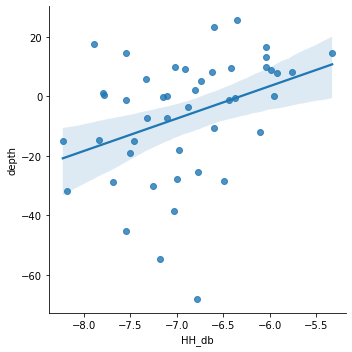

In [47]:
# overall linear regression
sns.lmplot(x='HH_db',y='depth',data=df)
plt.show()

In [ ]:
g = sns.lmplot(x="HH_db", y="depth", hue="logger", data=df, fit_reg=False,legend=False,palette='colorblind')
plt.legend(loc='lower right')
sns.regplot(x="HH_db", y="depth", data=df, scatter=False, ax=g.axes[0, 0])
g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
g.ax.set_ylabel("Water depth (cm)", fontsize = 14)

## 10:40 am HH and measurements version
- the radar images are taken around 10:40am, so using the water logger data corresponding with this time for best accuracy.
- currently only possible for the DRC loggers, until I get the sub-hourly data for the EKG loggers

In [52]:
# Procesing of the 10:40am RoC Ekolongouma data
EKG02_1040a = process_EKG_1040(EKG02_1040,'EKG02')
EKG03_1040a = process_EKG_1040(EKG03_1040,'EKG03')

In [ ]:
# checking that the data is in the correct order
df = EKG02_1040a.reset_index()
df.plot('index','Dates')

In [ ]:
# combining the EKG02 and EKG03 10:40am data 
EKG_loggers_1040 = pd.concat([EKG02_1040a,EKG03_1040a]).reset_index()
EKG_loggers_1040

# extracting the HH backscatter for each date
EKG_loggers_1040.rename(columns={'Dates':'Datetime'},inplace=True)

# extracting the datetime64 date only version of the datetime (normalised to 00:00 - required for extraction of HH data)
EKG_loggers_1040['Datetime']=EKG_loggers_1040['Datetime'].dt.normalize()

EKG_loggers_1040_df = extract_HH(EKG_loggers_1040, EKG_coords)
EKG_loggers_1040_df

y = 4.94x + 35.21
0.5365424474901317
0.6066718145443044


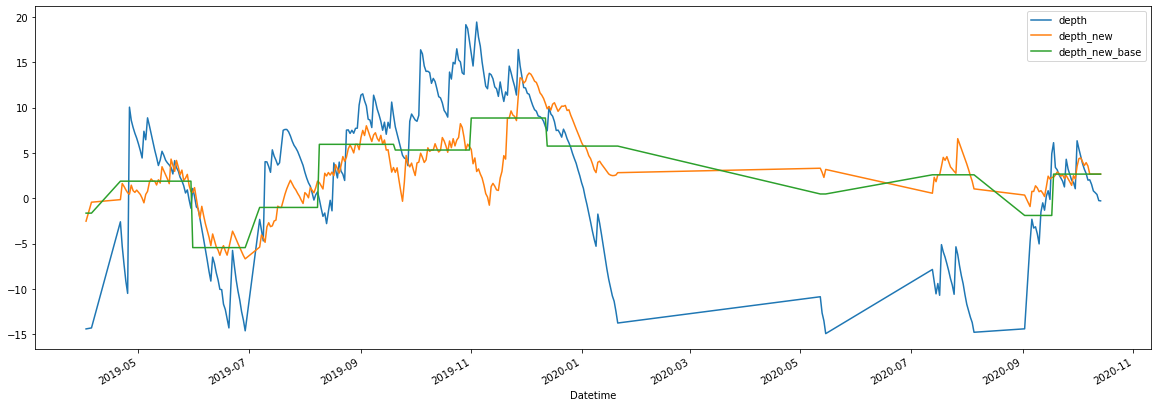

In [55]:
# Deriving the optimal transfer function coefficients using the polyfit method
df = EKG_loggers_1040_df[EKG_loggers_1040_df['logger']=='EKG03'].copy()

df['HH_db_10'] = df['HH_db'].rolling(10).median()
df = df[df['Datetime']<'2020-10-15']
df = df[df['Datetime']>'2019-04-01']
df = df[df['depth']>-15]
coeffs_l = np.polyfit(df['HH_db_10'],df['depth'],1)

print ("y = {}x + {}".format(np.around(coeffs_l[0],2),np.around(coeffs_l[1],2)))
coeffs = np.polyfit(df['HH_db_10'],df['depth'],2)
#print (coeffs)
# Print the equation of the line of best fit
#print("y = {}x**2 + {}x + {}".format(coeffs[0], coeffs[1], coeffs[2]))

# quadratic
#df['depth_new'] = coeffs[0] * df['HH_db']**2 + coeffs[1] * df['HH_db'] + coeffs[2]

# linear
df['depth_new'] = coeffs_l[0] * df['HH_db'] + coeffs_l[1] 
df['depth_new_base'] = coeffs_l[0] * df['HH_db_orig'] + coeffs_l[1] 
df[df['logger']=='EKG03'].plot('Datetime',['depth', 'depth_new','depth_new_base'])

# checking the correlation
print (df['depth'].corr(df['depth_new']))
print (df['depth'].corr(df['depth_new_base']))

# This polyfit method gives a linear regression equation: water level = 4.94*HH + 35.21 ---> so, the water is at the peat surface when the HH backscatter is ~ -7.1 dB
# This corresponds with the value derived using the water table depths measured along transects (see Determine_transfer_function_WTD_transects.ipynb)

In [ ]:
# selecting only the dates with corresponding radar data (need to do this for the 10:40 timestep)
EKG_loggers_1040_df2 = EKG_loggers_1040_df[EKG_loggers_1040_df['Datetime'].isin(HH_times)]
EKG_loggers_1040_df2.drop(['HH_db_orig','index'],axis=1,inplace=True)
EKG_loggers_1040_df2

In [ ]:
EKG_loggers_1040_df[EKG_loggers_1040_df['Datetime'].isin(HH_times)]

In [ ]:
# DRC data
loggers_1040 = loggers[loggers['times']=='10:40:00'].reset_index(drop=True)
loggers_1040

In [ ]:
loggers_1040['Datetime'] = pd.to_datetime(loggers_1040['Day'] + ' ' + loggers_1040['times'], dayfirst = True)
loggers_1040['Day'] = pd.to_datetime(loggers_1040['Day'], dayfirst = True)
loggers_1040.drop(['times'], axis = 1, inplace = True)
loggers_1040 = loggers_1040.sort_values('Datetime').reset_index(drop = True)

# checking that the datetime index is correct
loggers_1040.reset_index().plot('index','Datetime')


<AxesSubplot:xlabel='Datetime'>

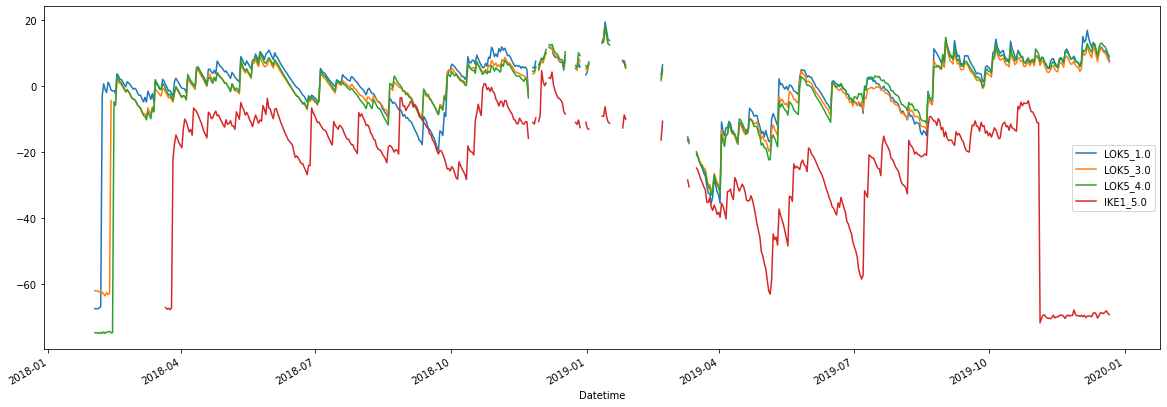

In [62]:
# Checking that the data looks sensible
plt.rcParams["figure.figsize"] = (20,7)
loggers_1040.plot('Datetime',['LOK5_1.0','LOK5_3.0','LOK5_4.0','IKE1_5.0'])

In [63]:
# subsetting the logger dataframes using the start and end date values of the available HH radar data
l_1040 = loggers_1040[(loggers_1040['Datetime'] >= np.array(start_date)) & (loggers_1040['Datetime']<=np.array(end_date))]
l_1040.drop('pressure_kpa',axis=1,inplace=True)
l_1040 = l_1040.reset_index()

In [65]:
# adding columns with the nearest daily HH reflectivity value
# make this into a function for final code version

l_names = ['LOK5_1.0','LOK5_3.0','LOK5_4.0','IKE1_5.0']

df = l_1040.copy()

df['HH_db_' + l_names[0]] = np.nan
df['HH_db_' + l_names[1]] = np.nan
df['HH_db_' + l_names[2]] = np.nan
df['HH_db_' + l_names[3]] = np.nan
    
# looping through the loggers 
for i in range(len(l_names)):
    lat1 = l_coords['lat'][i]
    lon1 = l_coords['lon'][i]

    print ("Extracting the HH backscatter values for: " + l_names[i] + ' lat: ' + str(lat1) + ', lon: ' + str (lon1))
        
    # looping through the rows (date-time steps)
    for j in range(len(df)):

        # the date to extract the backscatter value on
        dt1 = df['Datetime'][j]
        df['HH_db_' + l_names[i]][j] = HH_daily_fb.sel(time=dt1,lon=lon1,lat=lat1, method='nearest')['db']
        #transects['HH_db_linear'][i] = HH_db_linear.sel(time=dt1,lon=lon1,lat=lat1, method='nearest')['db']
        # some HH_db values are nan due to there not being close values for extraction - removing these
        #transects_df = transects.dropna()
    

l_1040 = df.copy()
l_1040

Extracting the HH backscatter values for: LOK5_1.0 lat: -0.3032, lon: 18.20069
Extracting the HH backscatter values for: LOK5_3.0 lat: -0.31495, lon: 18.1871
Extracting the HH backscatter values for: LOK5_4.0 lat: -0.32095, lon: 18.18046
Extracting the HH backscatter values for: IKE1_5.0 lat: 0.28348, lon: 18.82755


,index,Day,LOK5_1.0,LOK5_3.0,LOK5_4.0,IKE1_5.0,Datetime,HH_db_LOK5_1.0,HH_db_LOK5_3.0,HH_db_LOK5_4.0,HH_db_IKE1_5.0
0,421,2019-03-29,-29.959774,-27.989604,-28.531293,-37.230715,2019-03-29 10:40:00,-7.254726,-7.002114,-7.682165,-7.656335
1,422,2019-03-30,-32.040627,-29.200457,-29.982146,-38.861567,2019-03-30 10:40:00,-7.332380,-7.182412,NaN,-7.717231
2,423,2019-03-31,-32.969364,-30.009194,-30.730883,-38.200305,2019-03-31 10:40:00,-7.165206,-6.862788,-4.370572,-7.651537
3,424,2019-04-01,-35.454585,-31.784415,-32.556104,-39.775526,2019-04-01 10:40:00,-7.234586,-6.995669,-7.271266,-7.700499
4,425,2019-04-02,-10.901037,-13.240867,-14.652556,-35.461978,2019-04-02 10:40:00,-7.300034,-7.124374,-10.063671,-7.746194
...,...,...,...,...,...,...,...,...,...,...,...
263,684,2019-12-17,10.668333,10.238503,12.276814,-68.932608,2019-12-17 10:40:00,-5.623513,-5.724733,NaN,-7.113114
264,685,2019-12-18,10.657280,10.067450,11.945761,-68.473661,2019-12-18 10:40:00,-5.746704,-5.953241,NaN,-7.208930
265,686,2019-12-19,10.056675,9.316845,11.085156,-68.084266,2019-12-19 10:40:00,-5.694052,-5.819187,NaN,-7.296747
266,687,2019-12-20,8.876138,8.096307,9.824618,-68.914803,2019-12-20 10:40:00,-5.663005,-5.797283,NaN,-7.363923


In [ ]:
%%time
# re-arranging the dataframe column structure for easier plotting/data management
dfs = []

for i in range(len(l_names)):
    df_new = l_1040[['Datetime','Day',l_names[i],'HH_db_'+l_names[i]]]
    df_new = df_new.rename(columns={l_names[i]:'depth','HH_db_'+l_names[i]:'HH_db'})
    df_new['logger'] = l_names[i]
    dfs.append(df_new)  
    
# merging these dataframes
#dfs = [df.set_index(['Day','logger']) for df in dfs]
loggers_1040_df = pd.concat(dfs, axis=0).reset_index(drop=True)
loggers_1040_df

In [67]:
# selecting only the dates with corresponding radar data 
loggers_1040_df = loggers_1040_df[loggers_1040_df['Day'].isin(HH_times)]

In [ ]:
# combining the DRC and EKG 10:40am logger data 
# formatting and saving to file
df1 = loggers_1040_df.copy()
df2 = EKG_loggers_1040_df2.copy()
df2['Day'] = df2['Datetime']
df1['Datetime'] = df1['Day']
df = pd.concat([df1,df2],ignore_index=True)
df['Datetime'] = df['Datetime'] + pd.Timedelta(hours=10,minutes=40)
All_loggers_1040_df = df.copy()
df.to_feather(ALOS + 'All_loggers_1040_df')
df

 water level = 12.72HH + 93.98
R = 0.425, p value = 0.0018849298, std error = 3.872 cm


Text(0, 0.5, 'Water depth (cm)')

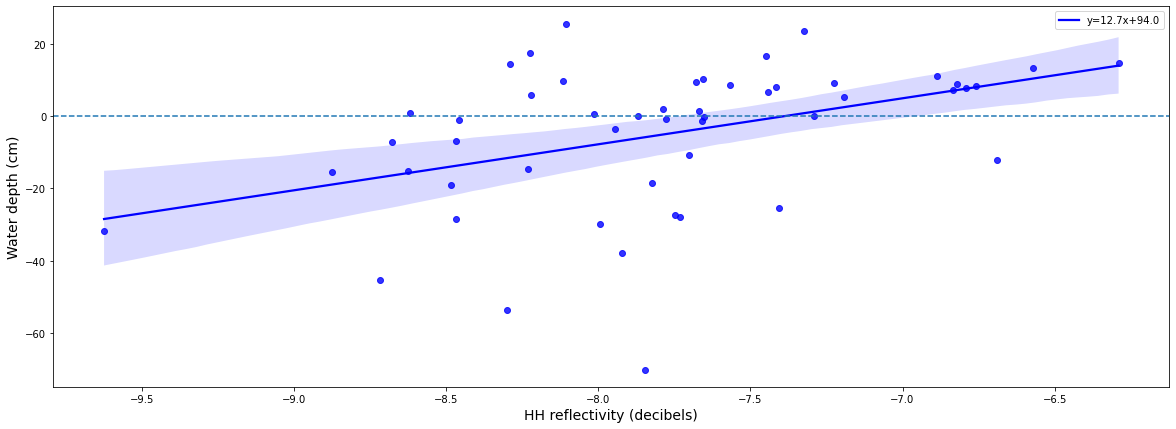

In [68]:
df = All_loggers_1040_df.copy()
df = df[df['HH_db']>-10]
df = df[df['logger'].isin(all_names[:5])]   # not including IKE1.

slope, intercept, r_value, p_value, std_err = stats.linregress(df['HH_db'],df['depth'])

print (" water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')
# use line_kws to set line label for legend
ax = sns.regplot(x="HH_db", y="depth", data=df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.axhline(0, ls='--')
# plot legend
ax.legend()
ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
ax.set_ylabel("Water depth (cm)", fontsize = 14)

Text(15.674999999999997, 0.5, 'Water depth (cm)')

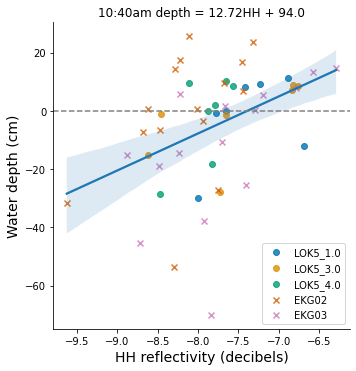

In [69]:
g = sns.lmplot(x="HH_db", y="depth", hue="logger", data=df, fit_reg=False,legend=False, markers=['o','o','o','x','x'],palette='colorblind')
plt.legend(loc='lower right')

sns.regplot(x="HH_db", y="depth", data=df, scatter=False, ax=g.axes[0, 0])
g.ax.axhline(0, ls='--',c='gray')
ax = g.axes[0,0]
g.ax.set_title("10:40am depth = {0:.2f}HH + {1:.1f}".format(slope,intercept))
g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
g.ax.set_ylabel("Water depth (cm)", fontsize = 14)

In [70]:
# stats for each individual water logger at 10:40

for i in range(len(all_names)):
    df = All_loggers_1040_df.copy()
    df = df[df['logger'].isin(all_names[i:i+1])]
    df = df[df['HH_db']>-10]
    #df = df[df['depth']>-45]
    # stats over all data points
    m, c, r, p, std_err = stats.linregress(df['HH_db'],df['depth'])
    print ('Logger ' + all_names[i] + ': depth = '+ str(round(m,1)) + '*HH + ' + str(round(c,1)))
    print ('R2 = ' +str(round(r**2,2)) + ', p-value = ' + str(round(p,2)) + ', std error = ' + str(round(std_err,2)) + '\n')


Logger EKG02: depth = 17.7*HH + 142.9
R2 = 0.23, p-value = 0.07, std error = 9.1

Logger EKG03: depth = 17.4*HH + 121.3
R2 = 0.31, p-value = 0.03, std error = 7.19

Logger LOK5_1.0: depth = 12.6*HH + 90.7
R2 = 0.17, p-value = 0.36, std error = 12.6

Logger LOK5_3.0: depth = 11.0*HH + 80.5
R2 = 0.39, p-value = 0.13, std error = 6.18

Logger LOK5_4.0: depth = 32.8*HH + 256.4
R2 = 0.43, p-value = 0.11, std error = 16.83

Logger IKE1_5.0: depth = -15.9*HH + -171.2
R2 = 0.12, p-value = 0.45, std error = 19.35



In [ ]:
# plotting the combined DRC and EKG regression
# and calculating the linear regression stats
# 10:40am version to correspond with the radar data
df = All_loggers_1040_df.copy()
#df = df[df['logger'].isin(all_names[1:4])]
df = df[df['depth']>-20]
# stats over all data points
m, c, r, p, std_err = stats.linregress(df['HH_db'],df['depth'])
print ('depth = '+ str(m) + '*HH + ' + str(c))
print ('R2 = ' +str(r**2) + ', p-value = ' + str(p) + ', std error = ' + str(std_err))

g = sns.lmplot(x="HH_db", y="depth", hue="logger", data=df, fit_reg=False,legend=False,palette='colorblind')
plt.legend(loc='lower right')
sns.regplot(x="HH_db", y="depth", data=df, scatter=False, ax=g.axes[0, 0])
g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
g.ax.set_ylabel("Water depth (cm)", fontsize = 14)

In [ ]:
# Plotting linear regression
# and calculating the linear regression stats
# 10:40am version to correspond with the radar data
df = loggers_1040_df.copy()
df = df[df['logger'].isin(l_names[:3])]

# stats over all data points
m, c, r, p, std_err = stats.linregress(df['HH_db'],df['depth'])
print ('depth = '+ str(m) + '*HH + ' + str(c))
print ('R2 = ' +str(r**2) + ', p-value = ' + str(p) + ', std error = ' + str(std_err))

g = sns.lmplot(x="HH_db", y="depth", hue="logger", data=df, fit_reg=False,legend=False, markers=['o','o','o'],palette='colorblind')
plt.legend(loc='lower right')
sns.regplot(x="HH_db", y="depth", data=df, scatter=False, ax=g.axes[0, 0])
g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
g.ax.set_ylabel("Water depth (cm)", fontsize = 14)

## Processing water table depth measurements 
- colocated with GHG flux measurements
- combine these with the median logger measurements
- test combining them with the 10:40 measurements as they would all have been taken during daylight hours and may correspond better with the 10:40 data.

In [70]:
# reorganising the transects dataframe
transects = transects_orig.copy()
transects.rename(columns = {'Latitude':'lat','Longitude':'lon','WTD_corrected':'depth'}, inplace = True)
transects['datetime'] = pd.to_datetime(transects['date'], dayfirst=True)
transects = transects [['datetime','date','lat','lon','transect_season','season','km_number','depth','CH4_mg']]
transects = transects.sort_values(by='datetime').reset_index(drop=True)
transects

,datetime,date,lat,lon,transect_season,season,km_number,depth,CH4_mg
0,2019-02-15,15/02/2019,1.194690,17.857590,Ekolongouma-dry,dry,7,-17.0,-0.03
1,2019-02-15,15/02/2019,1.194690,17.857590,Ekolongouma-dry,dry,7,-17.0,0.00
2,2019-02-15,15/02/2019,1.192190,17.848970,Ekolongouma-dry,dry,6,-20.0,0.03
3,2019-02-15,15/02/2019,1.194690,17.857590,Ekolongouma-dry,dry,7,-17.0,0.04
4,2019-02-15,15/02/2019,1.192190,17.848970,Ekolongouma-dry,dry,6,-20.0,0.01
...,...,...,...,...,...,...,...,...,...
353,2020-10-29,29/10/2020,0.329375,18.241016,Ipombo-wet,wet,1,20.0,15.30
354,2020-10-29,29/10/2020,0.329375,18.241016,Ipombo-wet,wet,1,48.0,67.00
355,2020-10-30,30/10/2020,0.333361,18.214351,Ipombo-wet,wet,4,12.2,0.30
356,2020-10-30,30/10/2020,0.333361,18.214351,Ipombo-wet,wet,4,10.0,0.40


In [ ]:
#test = transects[transects['transect_season']=='Itanga-dry']
# checking that the datetimes are ok (there was a previous issue with the ordering).
transects.reset_index().plot('index','datetime')

In [ ]:
%%time
# Extracting backscatter HH values

# adding a column with the nearest HH reflectivity value
transects['HH_db'] = np.nan
transects['HH_db_orig'] = np.nan
# 15 image ALOS-2 timeseries
#transects['HH_db_orig'] = np.nan

# linearly interpolated backscatter values, for comparison with the daily interpolated ones using the net water input
#transects['HH_db_linear'] = np.nan

for i in range(len(transects)):
    #print (i)
    dt1 = transects['datetime'][i]
    lat1 = transects['lat'][i]
    lon1 = transects['lon'][i]
    transects['HH_db'][i] = HH_daily_fb['db'].sel(time=dt1,lon=lon1,lat=lat1, method='nearest')
    transects['HH_db_orig'][i] = HH_db_100m['db'].sel(time=dt1,lon=lon1,lat=lat1, method='nearest')
    
# some HH_db values are nan due to there not being close values for extraction - removing these
transects = transects.dropna()

transects

In [79]:
# Not enough points to look at wet season points individually (each individual transect gives quite different results alone)

wet_list = ['Ipombo-wet','Lokolama-wet','Mpeka-wet']
dry_list = ['Boboka-dry','Bondzale-dry','Ekolongouma-dry','Ikelamba-dry','Ipombo-dry','Itanga-dry','Lobaka-dry','Mpeka-dry']

df_wet = df[df['transect_season'].isin(wet_list)]
df_dry = df[df['transect_season'].isin(dry_list)]

slope, intercept, r_value, p_value, std_err = stats.linregress(df_dry['HH_db'],df_dry['depth'])

print (" Dry transects water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')


slope, intercept, r_value, p_value, std_err = stats.linregress(df_wet['HH_db'],df_wet['depth'])

print (" Wet transects water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')


 Dry transects water level = 6.8HH + 25.51
R = 0.473, p value = 0.0010191564, std error = 1.929 cm
 Wet transects water level = 6.36HH + 48.2
R = 0.599, p value = 0.0041001078, std error = 1.95 cm


In [80]:
transects_df = transects.copy()
wet_list = ['Ipombo-wet','Lokolama-wet','Mpeka-wet']
dry_list = ['Boboka-dry','Bondzale-dry','Ekolongouma-dry','Ikelamba-dry','Ipombo-dry','Itanga-dry','Lobaka-dry','Mpeka-dry']
transects_df3 = transects_df[transects_df['transect_season'].isin(wet_list)]
transects_df3

transects_df4 = transects_df[transects_df['transect_season'].isin(dry_list)]

## Combining the water logger (10:40am) and transects data

In [ ]:
df1 = All_loggers_1040_df.copy()

# selecting all loggers, except for IKE which seems to have outlying data
df1 = df1[df1['logger'].isin(all_names[0:5])] 

df2 = transects_median.copy()

# common columns are Datetime, depth, HH_db
# change the name of the 'logger' and 'transect_season' columns to the same 'id'
df1.rename({'logger':'id','Datetime':'date'},axis=1, inplace=True)
df2.rename({'transect_season':'id'},axis=1,inplace=True)

df1 = df1[['date','id','depth','HH_db']]
df2 = df2[['date','id','depth','HH_db']]

df_all = pd.concat([df1,df2]).reset_index(drop=True)

df_all = df_all[df_all['HH_db']>-12]

slope, intercept, r_value, p_value, std_err = stats.linregress(df_all['HH_db'],df_all['depth'])

print (" water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')
# use line_kws to set line label for legend
ax = sns.regplot(x="HH_db", y="depth", data=df_all, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.axhline(0, ls='--')
# plot legend
ax.legend()
ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
ax.set_ylabel("Water depth (cm)", fontsize = 14)

Text(15.674999999999997, 0.5, 'Water depth (cm)')

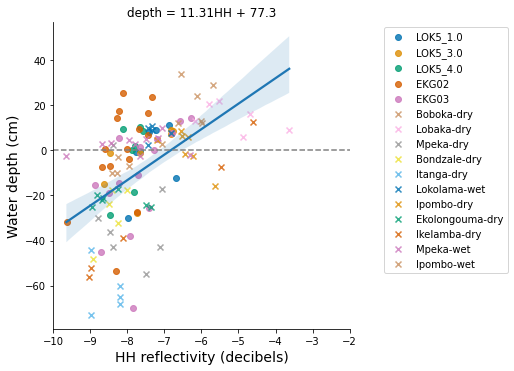

In [92]:
# test - including both water loggers and transect depths
m_list =['o','o','o','o','o','x','x','x','x','x','x','x','x','x','x','x',]
g = sns.lmplot(x="HH_db", y="depth", hue="id", data=df_all, fit_reg=False,legend=False, markers=m_list,palette='colorblind')
plt.legend(bbox_to_anchor=(1.1, 1.0))
g.set(xlim = (-10,-2))
#g.set(ylim = (-70,60))
sns.regplot(x="HH_db", y="depth", data=df_all, scatter=False, ax=g.axes[0, 0])
g.ax.axhline(0, ls='--',c='gray')
ax = g.axes[0,0]
g.ax.set_title("depth = {0:.2f}HH + {1:.1f}".format(slope,intercept))
g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
g.ax.set_ylabel("Water depth (cm)", fontsize = 14)

## Assessing the relationship between net water input and the daily change in water level

In [ ]:
# subsetting the logger dataframes using the start and end date values of the available HH radar data
l_median2 = DRC_median[(DRC_median['Datetime'] >= np.array(start_date)) & (DRC_median['Datetime']<=np.array(end_date))]
l_stdev2 = DRC_stdev[(DRC_stdev['Datetime'] >= np.array(start_date)) & (DRC_stdev['Datetime']<=np.array(end_date))]

# dropping rows where all loggers have nan value (due to too high daily standard deviations)
l_median2 = l_median2.dropna(subset=l_names)
l_median2 = l_median2.reset_index()

l_stdev2 = l_stdev2.dropna(subset=l_names)
l_stdev2 = l_stdev2.reset_index()

l_median2

In [ ]:
## Tests

#calculate_deltaWL(EKG_loggers,'EKG02',EKG_coords,nw_daily)
calculate_deltaWL(l_median2,'LOK5_1.0',l_coords,nw_daily)

In [ ]:
calculate_deltaWL_EKG(EKG_loggers_df,'EKG02',EKG_coords,nw_daily)